In [ ]:
#!pip install tensorflow
#!pip install keras

In [53]:
from google.colab import drive
import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping


In [54]:
drive.mount('/content/drive')
dataset_path = '/content/drive/MyDrive/TF_PI/dataset'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [55]:
# creacion de un ImageDataGenerator para cargar y procesar las imágenes
datagen = ImageDataGenerator(
    rescale=1.0/255.0,  # normalización de los píxeles a valores entre 0 y 1
    validation_split=0.2,  # 80% de datos para el entrenamiento y el 20% para validación
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

In [56]:
# preparar generador para el conjunto de entrenamiento
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(128, 128),  # tamaño al que se redimensionarán las imágenes, usa interpolación bicúbica
    batch_size=32,
    class_mode='categorical',  # para clasificación multiclase
    subset='training'
)

# preparar generador para el conjunto de validación
validation_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 3803 images belonging to 9 classes.
Found 949 images belonging to 9 classes.


In [57]:
print("Clases asignadas:", train_generator.class_indices)


Clases asignadas: {'Cardboard': 0, 'Food Organics': 1, 'Glass': 2, 'Metal': 3, 'Miscellaneous Trash': 4, 'Paper': 5, 'Plastic': 6, 'Textile Trash': 7, 'Vegetation': 8}


In [58]:

num_classes = 9

modelo_densenet = DenseNet121(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
modelo_densenet.trainable = False
# Añadir capas adicionales de clasificación
x = modelo_densenet.output
x = GlobalAveragePooling2D()(x)  # Reduce dimensionalidad sin perder información importante
x = Dense(256, activation='relu')(x)  # Añadir una capa densa intermedia
predictions = Dense(num_classes, activation='softmax')(x)  # Capa de salida con 'softmax' para clasificación multiclase


# Crear el modelo completo
model = Model(inputs=modelo_densenet.input, outputs=predictions)

# Descongelar las últimas capas de DenseNet para un fine-tuning
for layer in model.layers[-10:]:
  layer.trainable = True

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Definir EarlyStopping para detener el entrenamiento si no mejora
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Entrenar el modelo
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


119/119 ━━━━━━━━━━━━━━━━━━━━ 334s 3s/step - accuracy: 0.4858 - loss: 1.5111 - val_accuracy: 0.5342 - val_loss: 1.4723
Epoch 2/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 317s 3s/step - accuracy: 0.7210 - loss: 0.7941 - val_accuracy: 0.6238 - val_loss: 1.2495
Epoch 3/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 313s 3s/step - accuracy: 0.7914 - loss: 0.5849 - val_accuracy: 0.6354 - val_loss: 1.1967
Epoch 4/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 341s 3s/step - accuracy: 0.8183 - loss: 0.5013 - val_accuracy: 0.6365 - val_loss: 1.3442
Epoch 5/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 335s 3s/step - accuracy: 0.8546 - loss: 0.4136 - val_accuracy: 0.6607 - val_loss: 1.2540
Epoch 6/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 334s 3s/step - accuracy: 0.8840 - loss: 0.3400 - val_accuracy: 0.5933 - val_loss: 1.5635


30/30 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.6422 - loss: 1.1394
Precisión en validación: 0.64


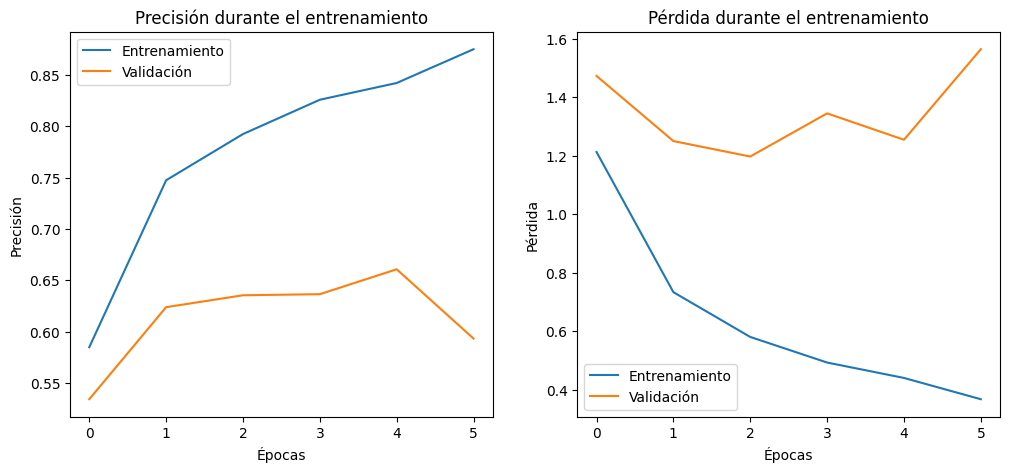

In [59]:
# Evaluar en el conjunto de validación
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f"Precisión en validación: {val_accuracy:.2f}")

# Graficar la precisión y la pérdida durante el entrenamiento
plt.figure(figsize=(12, 5))

# Gráfica de precisión
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Gráfica de pérdida
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.show()


In [49]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [60]:
# Generar predicciones en el conjunto de validación
Y_pred = model.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Obtener las etiquetas reales
y_true = validation_generator.classes

# Obtener los nombres de las clases
class_names = list(validation_generator.class_indices.keys())

30/30 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step


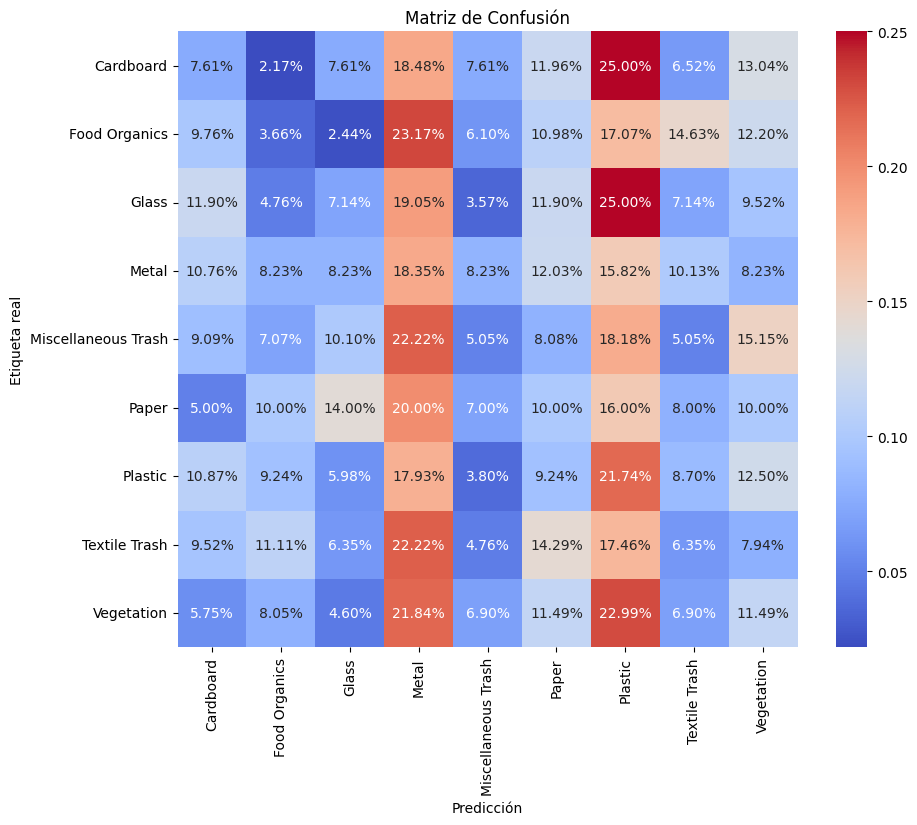

In [61]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Normalizar la matriz de confusión por filas
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Visualizar el heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt=".2%", cmap='coolwarm', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicción')
plt.ylabel('Etiqueta real')
plt.title('Matriz de Confusión')
plt.show()


In [62]:
# Inicializar arrays para TP, FP, FN y TN
TP = np.diag(cm)  # Verdaderos Positivos
FP = cm.sum(axis=0) - TP  # Falsos Positivos
FN = cm.sum(axis=1) - TP  # Falsos Negativos
TN = cm.sum() - (FP + FN + TP)  # Verdaderos Negativos

# Total de predicciones para cada clase (columnas)
total_predictions_per_class = TP + FP + FN + TN  # Total para cada categoría predicha

# Convertir a porcentaje del total de predicciones por clase
TP_percent = TP / total_predictions_per_class * 100
FP_percent = FP / total_predictions_per_class * 100
FN_percent = FN / total_predictions_per_class * 100
TN_percent = TN / total_predictions_per_class * 100

In [63]:
import pandas as pd

# Crear un DataFrame para organizar los valores en porcentaje
metrics_df = pd.DataFrame({
    'Clase': class_names,
    'TP (Verdaderos Positivos %)': TP_percent,
    'FP (Falsos Positivos %)': FP_percent,
    'FN (Falsos Negativos %)': FN_percent,
    'TN (Verdaderos Negativos %)': TN_percent
})

# Mostrar la tabla
print(metrics_df)


                 Clase  TP (Verdaderos Positivos %)  FP (Falsos Positivos %)  \
0            Cardboard                     0.737619                 8.429926   
1        Food Organics                     0.316122                 7.060063   
2                Glass                     0.632244                 6.849315   
3                Metal                     3.055848                16.859852   
4  Miscellaneous Trash                     0.526870                 5.374078   
5                Paper                     1.053741                 9.799789   
6              Plastic                     4.214963                15.595364   
7        Textile Trash                     0.421496                 7.903056   
8           Vegetation                     1.053741                10.115911   

   FN (Falsos Negativos %)  TN (Verdaderos Negativos %)  
0                 8.956797                    81.875659  
1                 8.324552                    84.299262  
2                 8.21917

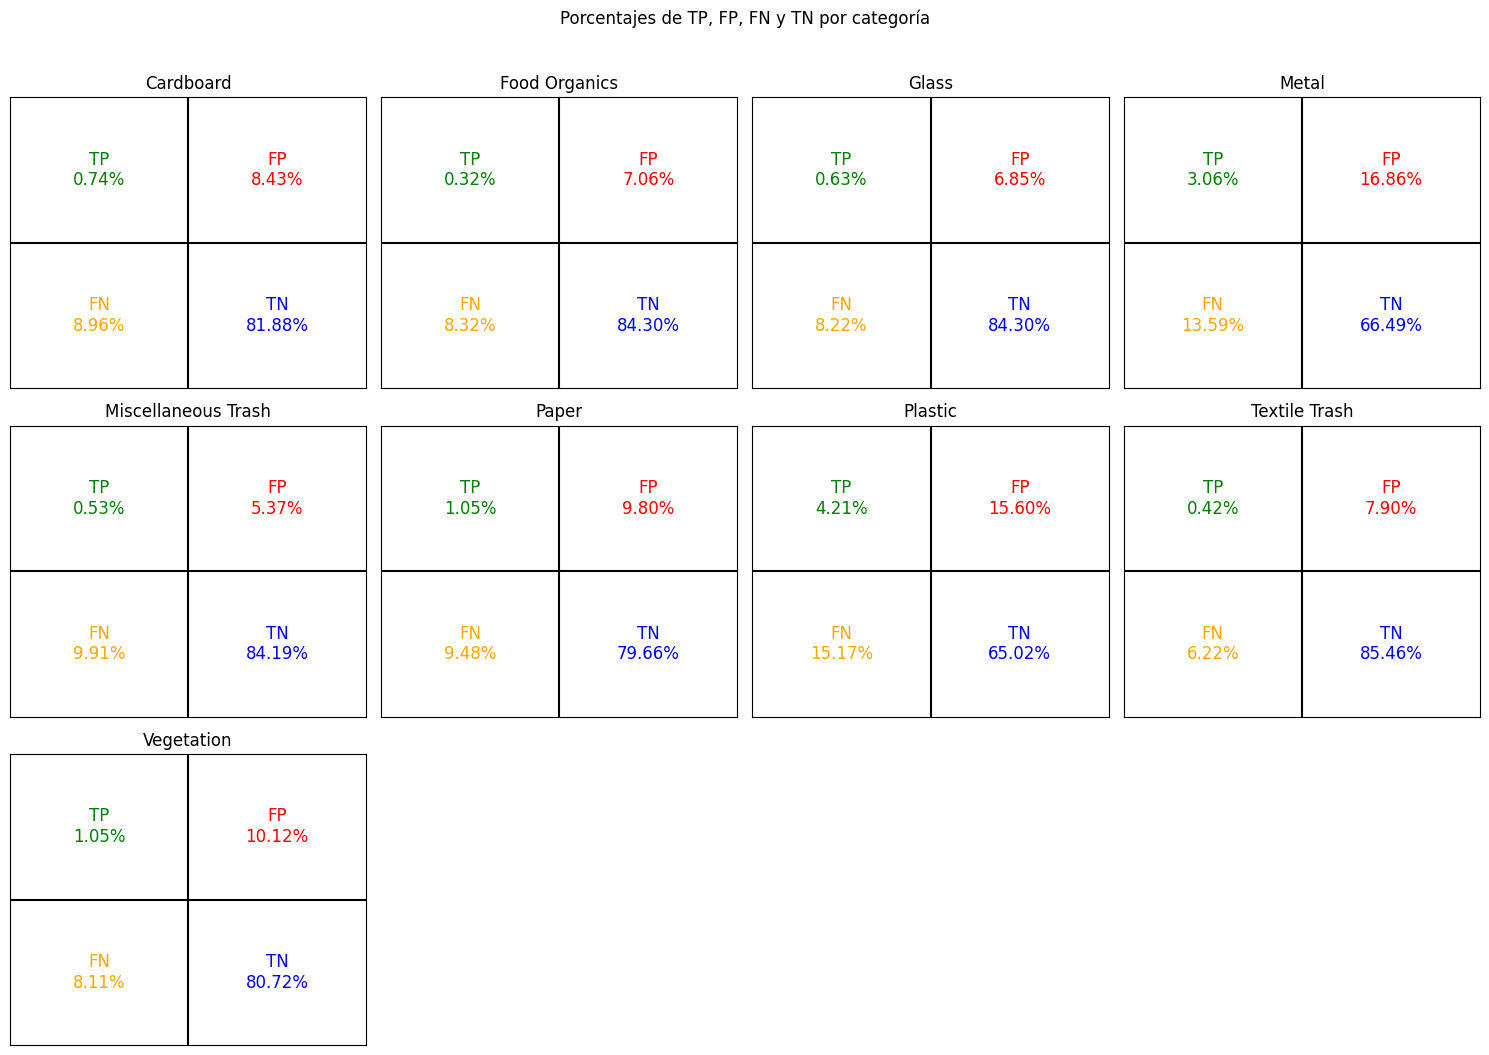

In [65]:
import matplotlib.pyplot as plt

# Configuración de la figura principal con 3 filas y 4 columnas
fig, axs = plt.subplots(3, 4, figsize=(15, 10))

# Aplanar el array de ejes para iterar fácilmente
axs = axs.ravel()

# Recorrer cada clase y mostrar los porcentajes en un cuadrado 2x2
for i in range(num_classes):
    # Obtener los porcentajes de TP, FP, FN y TN para la clase actual
    tp = TP_percent[i]
    fp = FP_percent[i]
    fn = FN_percent[i]
    tn = TN_percent[i]

    # Dibujar un cuadrado 2x2 en cada subplot
    axs[i].text(0.25, 0.75, f'TP\n{tp:.2f}%', ha='center', va='center', color='green', fontsize=12)
    axs[i].text(0.75, 0.75, f'FP\n{fp:.2f}%', ha='center', va='center', color='red', fontsize=12)
    axs[i].text(0.25, 0.25, f'FN\n{fn:.2f}%', ha='center', va='center', color='orange', fontsize=12)
    axs[i].text(0.75, 0.25, f'TN\n{tn:.2f}%', ha='center', va='center', color='blue', fontsize=12)

    # Configuración del título y formato de cada subplot
    axs[i].set_title(class_names[i])
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i].set_xlim(0, 1)
    axs[i].set_ylim(0, 1)
    axs[i].plot([0.5, 0.5], [0, 1], color='black')  # Línea vertical para dividir FP y TP
    axs[i].plot([0, 1], [0.5, 0.5], color='black')  # Línea horizontal para dividir FN y TP

# Ocultar los subplots vacíos si hay menos de 12 clases
for j in range(num_classes, len(axs)):
    axs[j].axis('off')

# Ajuste de la figura principal
plt.tight_layout()
plt.suptitle("Porcentajes de TP, FP, FN y TN por categoría", y=1.05)
plt.show()
